#Import Libraries

In [22]:
import pandas as pd
import numpy as np
import os

import time
import seaborn as sns

import math

import matplotlib.pyplot as plt

from google.colab import drive
from os import listdir
from os.path import isfile, join

from pprint import pprint


drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/nda'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import and Read the Data

In [23]:
def read_dataset(filename):
    span_lengths = []
    link_occupancies = []
    SNR_vect = []

    with open(filename) as data_file:
        next(data_file)
        for line in data_file:

            vals = line.split(";", 3)

            spans = vals[0].split(",")
            spans_list = [int(x) for x in spans]
            span_lengths.append(spans_list)

            occupancies = vals[1].split(',')
            occupancies_list = [int(x) for x in occupancies]
            link_occupancies.append(occupancies_list)

            snr = float(vals[2])
            SNR_vect.append(snr)

    data = pd.DataFrame({'SNR': SNR_vect, 'Span':span_lengths, 'Link':link_occupancies})

    return data

In [24]:
raw_data_path = PATH + '/raw_data/'
files = [f for f in listdir(raw_data_path) if isfile(join(raw_data_path, f))]
print(files)

['Dataset_european_19_node.dat', 'Dataset_german_17_node.dat']


In [25]:
raw_data_g = read_dataset(join(raw_data_path, files[0]))

raw_data_e = read_dataset(join(raw_data_path, files[1]))

#Extract Features

In [26]:
def extract_features(spans, links):
  features_matrix = []
  for s, l in zip(spans, links):
    features = []

    features.append(np.mean(s))
    features.append(np.shape(s)[0])
    features.append(np.max(s))
    features.append(np.min(s))
    features.append(np.std(s))

    features.append(np.mean(l))
    features.append(np.shape(l)[0])
    features.append(np.max(l))
    features.append(np.min(l))
    features.append(np.std(l))

    features_matrix.append(features)

  return np.array(features_matrix)

features_g = extract_features(raw_data_g['Span'], raw_data_g['Link'])
features_e = extract_features(raw_data_e['Span'], raw_data_e['Link'])

In [27]:
data_g = pd.DataFrame(features_g)
data_g = data_g.set_axis(['Span', 'Span_Len', 'Span_Max', 'Span_Min', 'Span_Std', 'Link', 'Link_Len', 'Link_Max', 'Link_Min', 'Link_Std'], axis=1, copy=False)
data_e = pd.DataFrame(features_e)
data_e = data_e.set_axis(['Span', 'Span_Len', 'Span_Max', 'Span_Min', 'Span_Std', 'Link', 'Link_Len', 'Link_Max', 'Link_Min', 'Link_Std'], axis=1, copy=False)

#Visualizing Data Distribution

SNR to MF Function

In [28]:
boundries = [8.7, 12.8, 15.2, 18.2, 21.0]

def SNR_to_MF(SNR):
    epsilon = 1e-6  # Small epsilon value for comparison

    if SNR < boundries[0] - epsilon:
        return 0

    elif (boundries[0] - epsilon <= SNR) and (SNR < boundries[1]):
        return 4

    elif (boundries[1] <= SNR) and (SNR < boundries[2]):
        return 8

    elif (boundries[2] <= SNR) and (SNR < boundries[3]):
        return 16

    elif (boundries[3] <= SNR) and (SNR < boundries[4]):
        return 32

    else:  # SNR >= 23.7:
        return 64


In [29]:
data_g['SNR'] = raw_data_g['SNR']
data_e['SNR'] = raw_data_e['SNR']

data_g['MF'] = [SNR_to_MF(s) for s in data_g['SNR']]
data_e['MF'] = [SNR_to_MF(s) for s in data_e['SNR']]

classes_g = np.unique(data_g['MF'], return_counts=True)
print(f"Unique Classes [Germany]:\t{classes_g[0]}")
classes_g = [str(x) for x in classes_g]
print(f"\t\tCounts:\t\t{classes_g[1]}")

classes_e = np.unique(data_e['MF'], return_counts=True)
classes_e = [str(x) for x in classes_e]
print(f"Unique Classes [Europe]:\t{classes_e[0]}")
print(f"\t\tCounts:\t\t{classes_e[1]}\n")

Unique Classes [Germany]:	[ 4  8 16]
		Counts:		[733 814 286]
Unique Classes [Europe]:	[ 8 16 32]
		Counts:		[658 930  84]



In [30]:
# Saving the datasets for further work

data_g.to_csv(PATH+'/new_data/GermanDataset.csv', index= False)
data_e.to_csv(PATH+'/new_data/EuropeanDataset.csv', index= False)

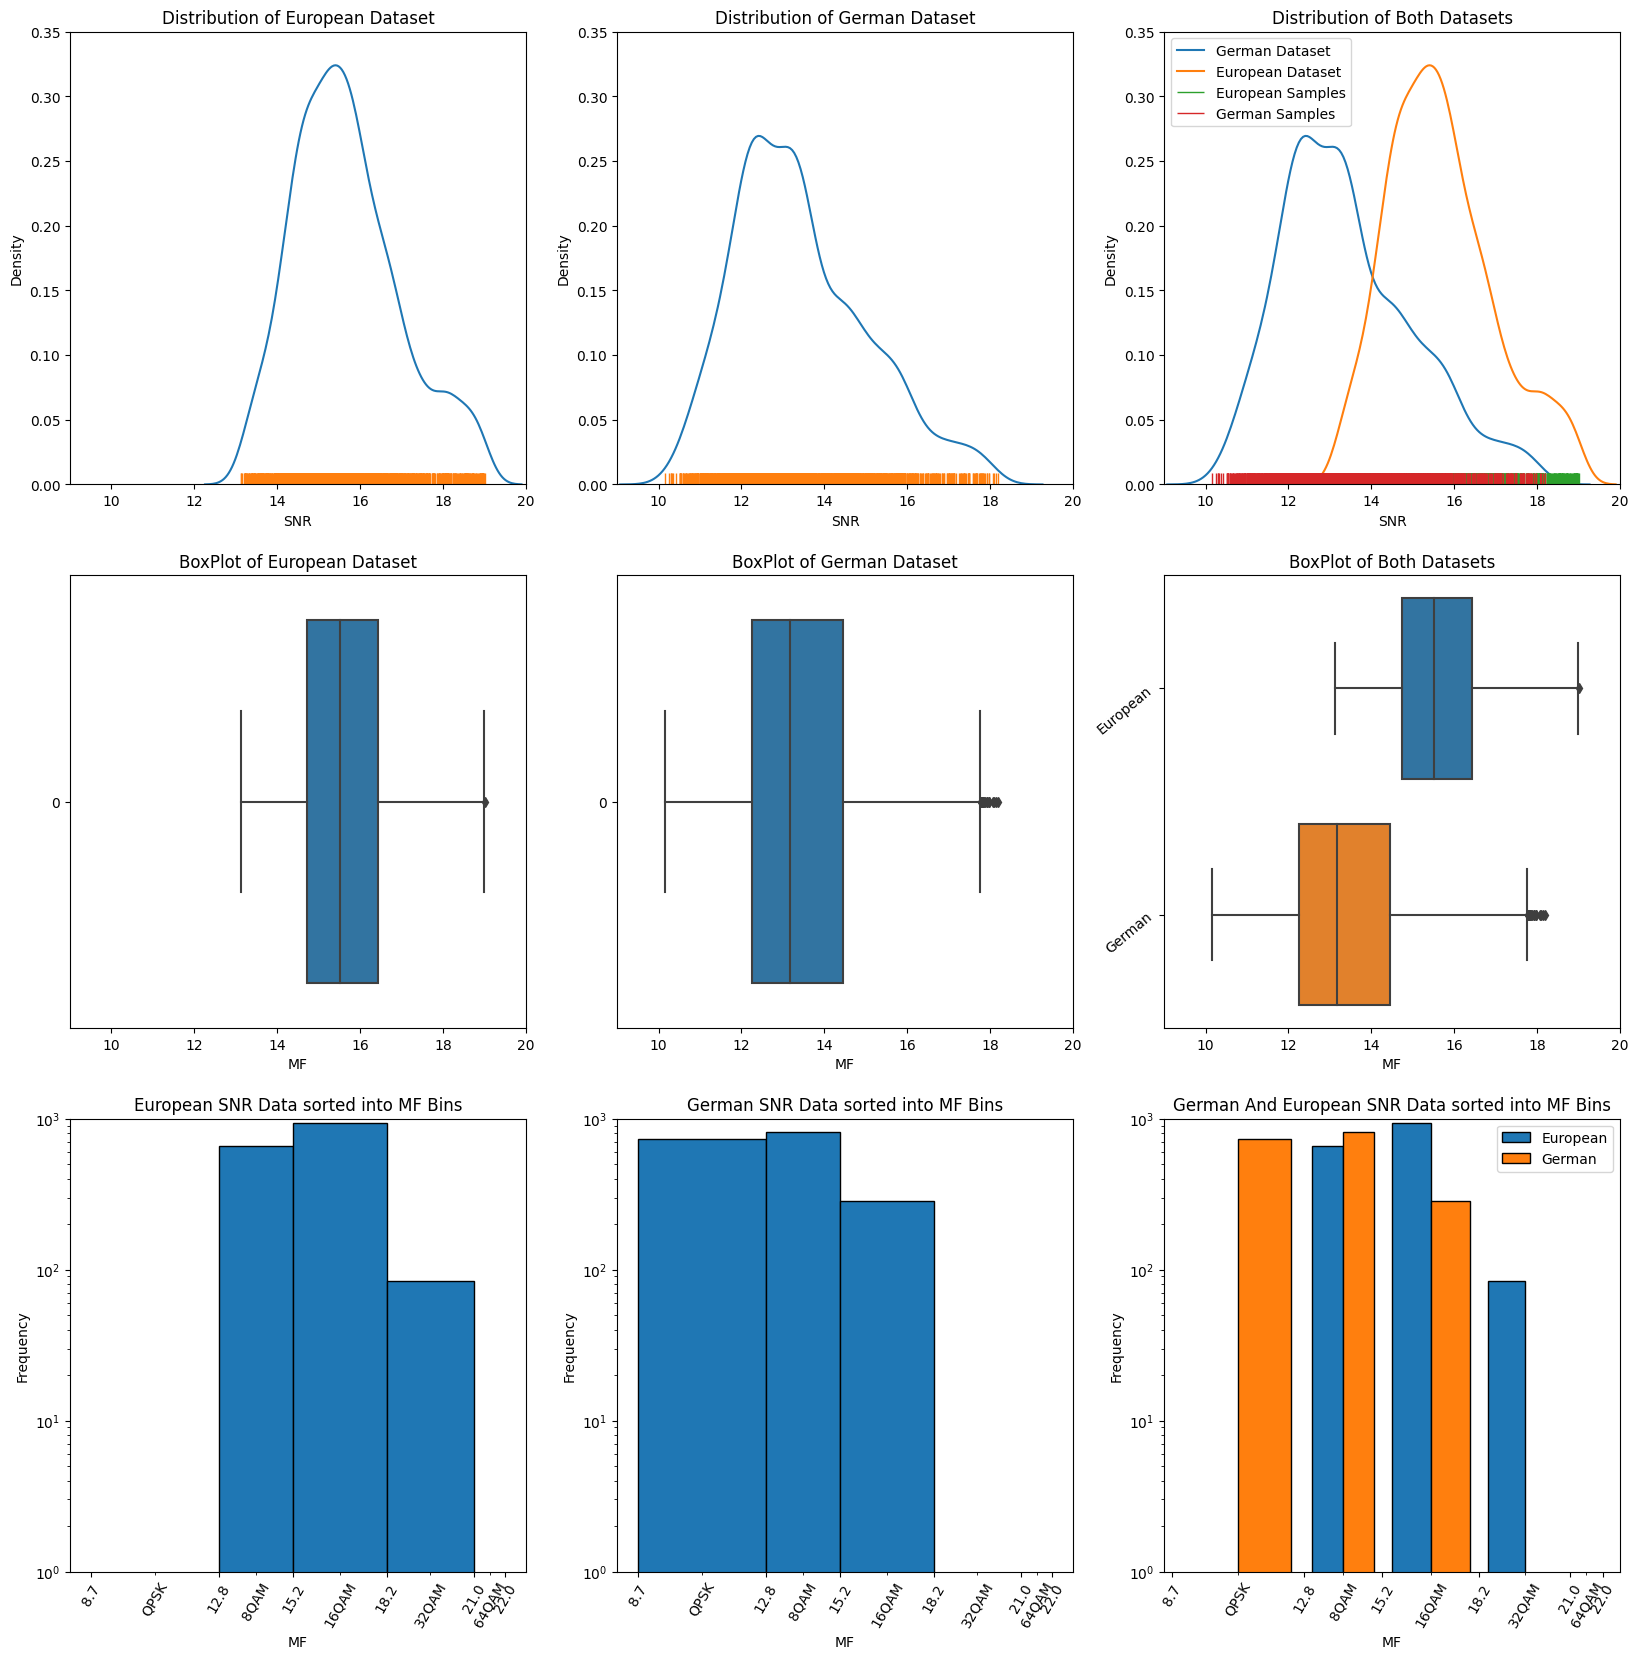

In [31]:
# Plots for both datasets

fig, ax = plt.subplots(3,3,figsize=(20, 20));

sns.kdeplot(data=data_e['SNR'], ax=ax[0][0])
sns.rugplot(data=data_e['SNR'], ax=ax[0][0])
ax[0][0].set_title("Distribution of European Dataset")
ax[0][0].set_xlim([9,20])
ax[0][0].set_ylim([0.0, 0.35])

sns.boxplot(data=data_e['SNR'], ax=ax[1][0], orient='h')
ax[1][0].set_title("BoxPlot of European Dataset")
ax[1][0].set_xlabel('MF')

ax[1][0].set_xlim([9,20])

sns.kdeplot(data=data_g['SNR'], ax = ax[0][1])
sns.rugplot(data=data_g['SNR'], ax = ax[0][1])
ax[0][1].set_title("Distribution of German Dataset")
ax[0][1].set_xlim([9,20])
ax[0][1].set_ylim([0.0, 0.35])
sns.boxplot(data=data_g['SNR'], ax=ax[1][1], orient='h')
ax[1][1].set_title("BoxPlot of German Dataset")
ax[1][1].set_xlim([9,20])
ax[1][1].set_xlabel('MF')


sns.kdeplot(data=data_g['SNR'], ax = ax[0][2], label='German Dataset')
sns.kdeplot(data=data_e['SNR'], ax = ax[0][2], label='European Dataset')
sns.rugplot(data=data_e['SNR'], ax = ax[0][2], label='European Samples')
sns.rugplot(data=data_g['SNR'], ax = ax[0][2], label='German Samples')
ax[0][2].set_title("Distribution of Both Datasets")
ax[0][2].set_xlim([9,20])
ax[0][2].set_ylim([0.0, 0.35])
ax[0][2].legend()

sns.boxplot(data=[data_e['SNR'], data_g['SNR']], ax=ax[1][2], orient='h')
ax[1][2].set_title("BoxPlot of Both Datasets")
ax[1][2].set_xlabel('MF')
ax[1][2].set_yticklabels(labels=['European','German'], rotation=40)
ax[1][2].set_xlim([9,20])


labels = ['QPSK', '8QAM', '16QAM', '32QAM', '64QAM']

bins_e = boundries.copy()
bins_g = boundries.copy()
bins2 = boundries.copy()
bins_e.append(max(boundries[-1] + 1, np.max(data_e['SNR'])))
bins_g.append(max(boundries[-1] + 1, np.max(data_g['SNR'])))
bins2.append(max(boundries[-1] + 1, np.max(data_g['SNR']), np.max(data_e['SNR'])))


minor = [np.mean([x,y]) for x, y in zip(bins_e, bins_e[1:])]
minor2 = [np.mean([x,y]) for x, y in zip(bins2, bins2[1:])]

ax[2][0].hist(data_e['SNR'], bins=bins_e, edgecolor='black', log=True)
counts_e, bins_e = np.histogram(data_e['SNR'], bins=bins_e)
ax[2][0].set_title('European SNR Data sorted into MF Bins')
ax[2][0].set_ylabel('Frequency')
ax[2][0].set_xlabel('MF')
ax[2][0].set_ylim([1,1000])
ax[2][0].set_xticks(bins_e)
ax[2][0].set_xticklabels(labels=bins_e, rotation=60)

ax[2][0].set_xticks(minor, minor=True)
ax[2][0].set_xticklabels(labels=labels, rotation=60, minor=True)


ax[2][1].hist(data_g['SNR'], bins=bins_g, edgecolor='black', log=True)
counts_g, bins_g = np.histogram(data_g['SNR'], bins=bins_g)
ax[2][1].set_title('German SNR Data sorted into MF Bins')
ax[2][1].set_ylabel('Frequency')
ax[2][1].set_xlabel('MF')
ax[2][1].set_ylim([1,1000])

ax[2][1].set_xticks(bins_g)
ax[2][1].set_xticklabels(labels=bins_g, rotation=60)

ax[2][1].set_xticks(minor, minor=True)
ax[2][1].set_xticklabels(labels=labels, rotation=60, minor=True)


ax[2][2].hist([data_e['SNR'], data_g['SNR']], bins=bins2, edgecolor='black', log=True)
ax[2][2].set_title('German And European SNR Data sorted into MF Bins')
ax[2][2].set_ylabel('Frequency')
ax[2][2].set_xlabel('MF')
ax[2][2].set_ylim([1,1000])
ax[2][2].legend(['European', 'German'])

ax[2][2].set_xticks(bins2)
ax[2][2].set_xticklabels(labels=bins2, rotation=60)

ax[2][2].set_xticks(minor2, minor=True)
ax[2][2].set_xticklabels(labels=labels, rotation=60, minor=True)




plt.show()